# General Travelling Sales Person

In addition to being a notorious NP-hard problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. 

Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time.

The problem derives its importance from its “hardness” and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.

The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of network graphs. 

The TSP on the nodes of a graph asks for the shortest Hamiltonian cycle that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.



In [49]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

In [50]:
filename="instanceType_euclidean_tsp_numNodes_4_numVehicles_1_87a170c748e240d0b71d5fb7fe7de707.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [51]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]


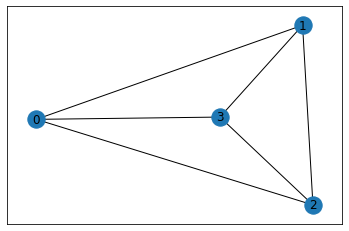

In [52]:
nx.draw_networkx(G)

In [53]:
# Create QAOA parameter dictionary
qaoa_dict = qaoa_vrp.utils.create_qaoa_params(threshold, n_max, p_max)

In [54]:
# Build Graph Feature Vector
feature_vector = qaoa_vrp.features.graph_features.get_graph_features(G)
# Build TSP Feature Vector
tsp_feature_vector = qaoa_vrp.features.tsp_features.get_tsp_features(G)
# Add num vehicles
feature_vector["num_vehicles"] = num_vehicles

In [55]:
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

In [56]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [57]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

big_offset = sum(sum(cost_mat))/2 + 1
qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info,A=big_offset)

qubos_solution_data = []

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [58]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 11.802651552078 X11 - 11.932160844816 X12 - 11.802651552078 X13
      - 11.477125852685 X21 - 11.932160844816 X22 - 11.477125852685 X23
      - 11.762377448228 X31 - 11.932160844816 X32 - 11.762377448228 X33 + [
      11.932160844816 X11^2 + 11.932160844816 X11*X12 + 11.932160844816 X11*X13
      + 11.932160844816 X11*X21 + 0.656366125546 X11*X22
      + 11.932160844816 X11*X31 + 0.573070695708 X11*X32 + 11.932160844816 X12^2
      + 11.932160844816 X12*X13 + 0.656366125546 X12*X21
      + 11.932160844816 X12*X22 + 0.656366125546 X12*X23
      + 0.573070695708 X12*X31 + 11.932160844816 X12*X32
      + 0.573070695708 X12*X33 + 11.932160844816 X13^2 + 0.656366125546 X13*X22
      + 11.932160844816 X13*X23 + 0.573070695708 X13*X32
      + 11.932160844816 X13*X33 + 11.932160844816 X21^2
      + 11.932160844816 X21*X22 + 11.932160844816 X21*X23
      + 11.932160844816 X21*X31 + 1.227988238

In [59]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])

# Solving the QAOA

Lets write some basic functions to find the solution from the result and also one to compute the cost based on our original graph

In [60]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()

In [61]:
print('Offset:', offset)
print('Ising Hamiltonian:')
print(op.print_details())

Offset: 19.881281478427255
Ising Hamiltonian:
IIIIIIIIZ	(-3.201474460229394+0j)
IIIIIIZII	(-3.201474460229394+0j)
IIIIIZIII	(-3.4461020027427596+0j)
IIIZIIIII	(-3.4461020027427596+0j)
IIZIIIIII	(-3.2930642762414735+0j)
ZIIIIIIII	(-3.293064276241474+0j)
IIIIIIIZI	(-3.2903994165175274+0j)
IIIIZIIII	(-3.454128802151119+0j)
IZIIIIIII	(-3.4333049446916064+0j)
IIIIIIIZZ	(1.4915201056019467+0j)
IIIIIIZIZ	(1.4915201056019467+0j)
IIIIIIZZI	(1.4915201056019467+0j)
IIIIIZIIZ	(1.4915201056019467+0j)
IIIIIZIZI	(0.082045765693287+0j)
IIIIZIIIZ	(0.082045765693287+0j)
IIIIZIIZI	(1.4915201056019467+0j)
IIIIZIZII	(0.082045765693287+0j)
IIIIZZIII	(1.4915201056019467+0j)
IIIZIIIZI	(0.082045765693287+0j)
IIIZIIZII	(1.4915201056019467+0j)
IIIZIZIII	(1.4915201056019467+0j)
IIIZZIIII	(1.4915201056019467+0j)
IIZIIIIIZ	(1.4915201056019467+0j)
IIZIIIIZI	(0.07163383696353035+0j)
IIZIIZIII	(1.4915201056019467+0j)
IIZIZIIII	(0.15349852978032563+0j)
IZIIIIIIZ	(0.07163383696353035+0j)
IZIIIIIZI	(1.4915201056019467+0j

In [62]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 5.836571 x_0 - 5.966080 x_1 - 5.836571 x_2 - 5.511045 x_3 - 5.966080 x_4
 - 5.511045 x_5 - 5.796297 x_6 - 5.966080 x_7 - 5.796297 x_8 [
 5.966080 x_0*x_1 + 5.966080 x_0*x_2 + 5.966080 x_0*x_3 + 0.328183 x_0*x_4
 + 5.966080 x_0*x_6 + 0.286535 x_0*x_7 + 5.966080 x_1*x_2 + 0.328183 x_1*x_3
 + 5.966080 x_1*x_4 + 0.328183 x_1*x_5 + 0.286535 x_1*x_6 + 5.966080 x_1*x_7
 + 0.286535 x_1*x_8 + 0.328183 x_2*x_4 + 5.966080 x_2*x_5 + 0.286535 x_2*x_7
 + 5.966080 x_2*x_8 + 5.966080 x_3*x_4 + 5.966080 x_3*x_5 + 5.966080 x_3*x_6
 + 0.613994 x_3*x_7 + 5.966080 x_4*x_5 + 0.613994 x_4*x_6 + 5.966080 x_4*x_7
 + 0.613994 x_4*x_8 + 0.613994 x_5*x_7 + 5.966080 x_5*x_8 + 5.966080 x_6*x_7
 + 5.966080 x_6*x_8 + 5.966080 x_7*x_8 ] + 17.898241;
 
subject to {

}


In [63]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 1.2395367993452244
optimal value: [0. 1. 0. 0. 0. 1. 1. 0. 0.]
status: SUCCESS


In [64]:
ee = NumPyMinimumEigensolver(op)
exact_result = ee.run()

In [65]:
print('energy:', exact_result.eigenvalue.real)
print('tsp objective:', exact_result.eigenvalue.real + offset)
x = sample_most_likely(exact_result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, cost_mat))

energy: -18.64174467908203
tsp objective: 1.239536799345224
feasible: True
solution: [2, 0, 1]
solution objective: 0.9127273476410219


## Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

We will show the callback usage below over a set of optimizers for comparison. Let's ensure we're giving each algorithm a fair shot.

- `SLSQP`
- `COBYLA`
- `NELDER_MEAD`
- `SPSA`
- `L_BFGS_B`

In [66]:
budget=500

In [67]:
optimizers = [
    SLSQP(maxiter=200, disp=True, eps=0.001),
    COBYLA(maxiter=200, disp=True), 
    NELDER_MEAD(maxiter=200),
    SPSA(maxiter=200),
    L_BFGS_B(maxiter=200, eps=0.001)
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
backend = Aer.get_backend('aer_simulator_matrix_product_state')

$$p = 1$$

In [68]:
p = 1
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__))
    counts = []
    values = []
    global_count = 0
    n_restart = 0
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        global global_count
        global_count += 1
        counts.append(eval_count)
        values.append(mean)
        
    while global_count < budget:
        # Increment n_restarts
        n_restart += 1
        # Initiate a random point uniformly from [0,1]
        initial_point = [np.random.uniform(0,1) for i in range(2*p)]         
        # Set random seed
        aqua_globals.random_seed = np.random.default_rng(123)
        seed = 10598
        # Initate quantum instance
        quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
        # Initate QALA
        qaoa = QAOA(
            operator=op,
            optimizer=optimizer,
            callback=store_intermediate_result,
            p=p,
            initial_point = initial_point,
            quantum_instance=quantum_instance
        )
        result = qaoa.compute_minimum_eigenvalue(operator=op)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)        
    
print('\rOptimization complete');    

Optimizer: SLSQP        
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.38872948129647
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7300763315509712
            Iterations: 7
            Function evaluations: 64
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2593270790260189
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.502938287574455
            Iterations: 6
            Function evaluations: 64
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1000442304913636
            Iterations: 2
      

In [70]:
results_dict = {
    "optimizer":None,
    "n_eval": None,
    "value": None
}

optimizer_dict = {
    0: "SLSQP",
    1: "COBYLA",
    2: "NELDER_MEAD",
    3: "SPSA",
    4: "L_BFGS_B"
}

d_results = []

for i,(evals, values) in enumerate(zip(converge_cnts, converge_vals)):
    for cnt, val in zip(evals, values):
        results_dict_temp = results_dict.copy()
        results_dict_temp["n_eval"] = cnt
        results_dict_temp["value"] = val
        results_dict_temp["optimizer"] = optimizer_dict[i]
        d_results.append(results_dict_temp)

d_results = pd.DataFrame.from_records(d_results)
# Add counter for num_evals
d_results['total_evals']=d_results.groupby('optimizer').cumcount()

In [71]:
d_results.to_csv("../data/results.csv")

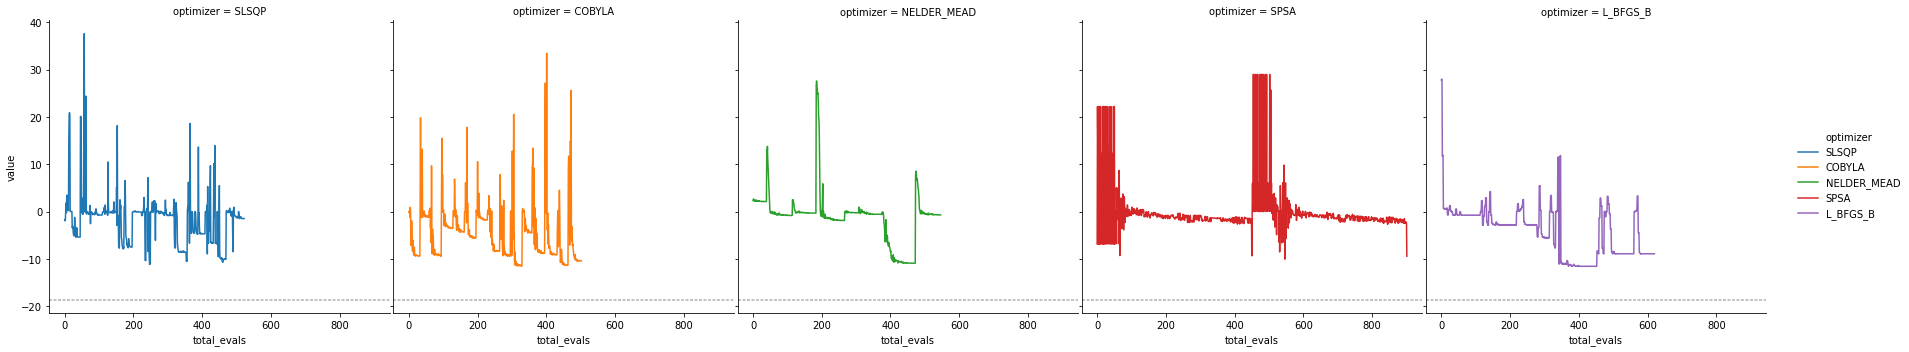

In [81]:
g = sns.relplot(
    data=d_results, x="total_evals", y="value",
    col="optimizer", hue="optimizer",
    kind="line"
)

(g.map(plt.axhline, y=-18.6, color=".7", dashes=(2, 1), zorder=0)
  .tight_layout(w_pad=0))

plt.show()

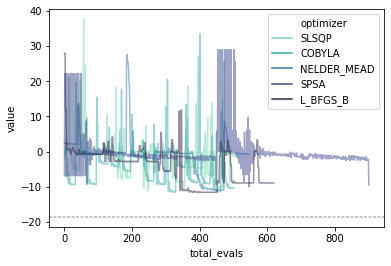

In [79]:
palette = sns.color_palette("mako_r", 5)
sns.lineplot(
    data=d_results, x="total_evals", y="value",
    hue="optimizer",
    palette=palette,
    alpha=0.5
)
plt.axhline(y=-18.6, color=".7", dashes=(2, 1), zorder=0)

In [74]:
x = sample_most_likely(result.eigenstate)
tsp.get_tsp_solution(x)

[2, 0, 1]

In [75]:
print('energy:', result.eigenvalue.real)

energy: -18.64174467908203


In [ ]:
resa